# Dynamic Selection Examples

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.tree import DecisionTreeClassifier

from brew.base import Ensemble, EnsembleClassifier
from brew.combination.combiner import Combiner
from brew.generation import Bagging
from brew.selection.dynamic import OLA, LCA,APriori, APosteriori, KNORA_UNION, KNORA_ELIMINATE

In [2]:
h = .05  # step size in the mesh

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

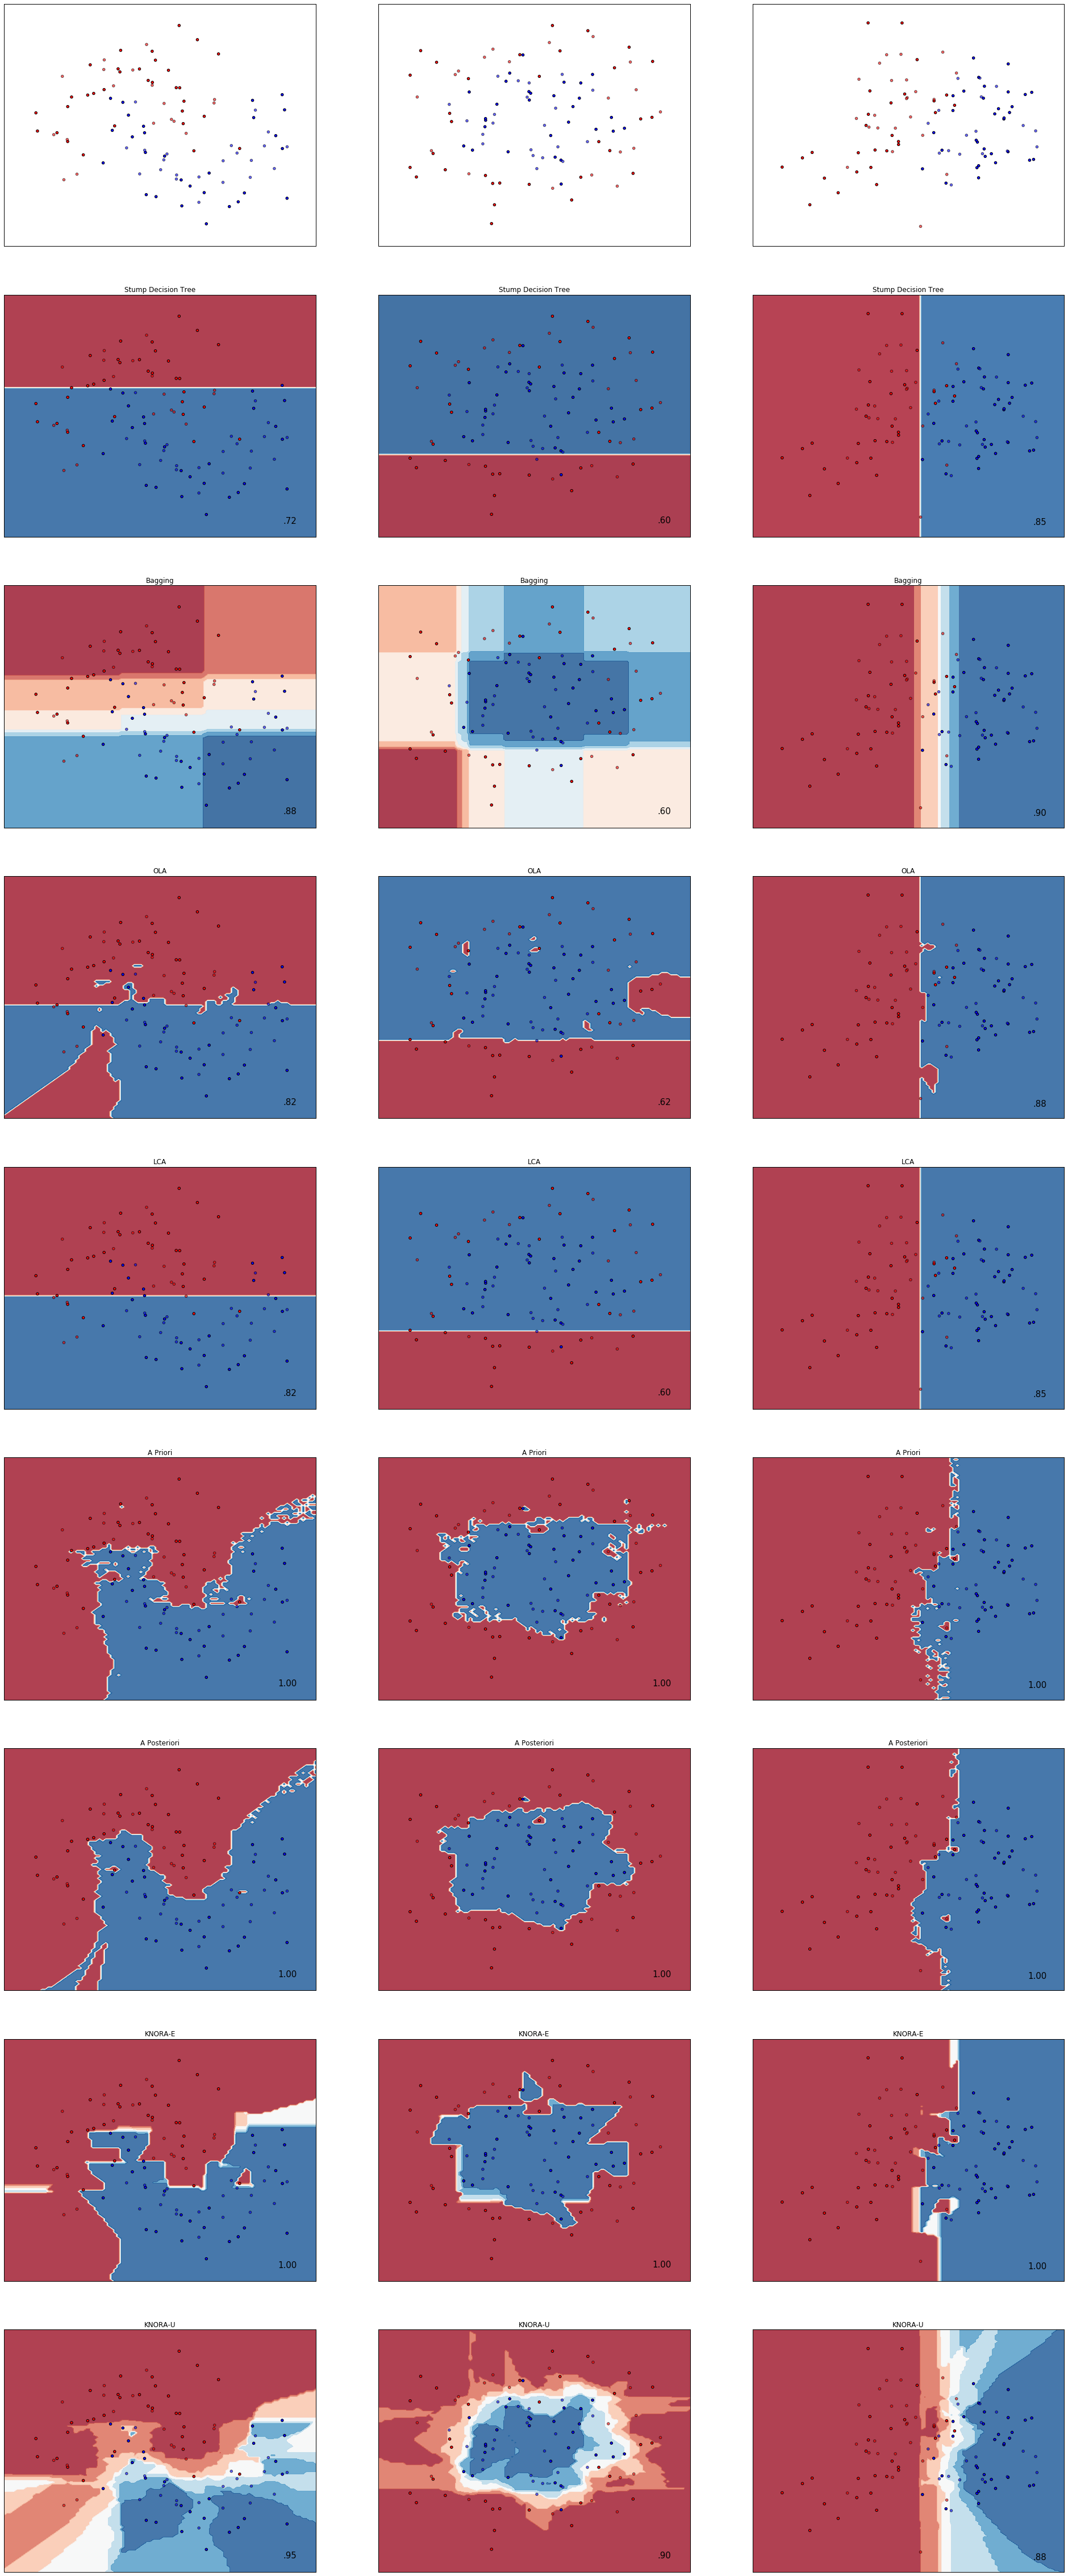

In [3]:
figure = plt.figure(figsize=(27, 3*27))
i = 1
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    #ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    ax = plt.subplot(9, len(datasets), i)
    
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    
    
    # Initializing ensemble of stump decision trees
    clf = DecisionTreeClassifier(max_depth=1)
    bag = Bagging(base_classifier=clf, n_classifiers=20)
    bag.fit(X_train, y_train)
    ensemble = bag.ensemble
    
    clf1 = sklearn.clone(clf).fit(X_train, y_train)
    clf2 = EnsembleClassifier(ensemble=ensemble, combiner=Combiner('mean'))
    clf3 = EnsembleClassifier(ensemble=ensemble, selector=OLA(X, y), combiner=Combiner('mean'))
    clf4 = EnsembleClassifier(ensemble=ensemble, selector=LCA(X, y), combiner=Combiner('mean'))
    clf5 = EnsembleClassifier(ensemble=ensemble, selector=APriori(X, y), combiner=Combiner('mean'))
    clf6 = EnsembleClassifier(ensemble=ensemble, selector=APosteriori(X, y), combiner=Combiner('mean'))
    clf7 = EnsembleClassifier(ensemble=ensemble, selector=KNORA_ELIMINATE(X, y), combiner=Combiner('mean'))
    clf8 = EnsembleClassifier(ensemble=ensemble, selector=KNORA_UNION(X, y), combiner=Combiner('mean'))
    
    
    classifiers = [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8]
    names = ['Stump Decision Tree', 'Bagging', 'OLA', 'LCA', 'A Priori', 'A Posteriori', 'KNORA-E', 'KNORA-U']

    # iterate over classifiers
    j = i + 3
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(9, len(datasets), j)
        #clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        j += 3
    i += 1
figure.subplots_adjust(left=.02, right=.98)
plt.show()